# <center>基于物理信息神经网络的粘性 Burgers 方程求解</center>

### <center>孙琪, 《应用与计算数学前沿讲座》，2024秋

## 1. 问题描述（**viscous Burgers' equation**）

### 初值问题 

记 $u = u(x,t)$ 为流场速度，$\epsilon$ 为粘性系数，粘性的 Burgers 方程具有如下形式
$$
u_t + u u_x = \epsilon u_{xx}, ~~x\in\mathbb{R},~~t>0,
$$
$$
u(x,0) = u_0(x), ~~x\in\mathbb{R},
$$
其中方程的左端项和右端项分别描述了流体的 **非线性对流** 和 **线性扩散** 效应（粘性项可以磨光对流项可能造成的激波，因此解通常有较好的光滑性）。


**解析求解：**通过 **Hopf-Cole变换** 将非线性问题转化为线性问题进行求解。具体的讲，首先引入函数 $\phi(x,t)$ 使得
$$
u(x,t) = \phi_x(x,t) ~~\xRightarrow{\text{带入到原方程中}}~~ \phi_{xt} + \phi_x \phi_{xx} = \epsilon \phi_{xxx} ~~\xRightarrow{\text{对 $x$ 进行积分}}~~ \phi_{t} + \frac{\phi_x^2}{2} = \epsilon \phi_{xx}.
$$
接下来，引入 **非线性变换** 可得
$$
\phi = -2\epsilon \ln(w) ~~\xRightarrow{\text{求导可得}}~~ \phi_t = -2\epsilon \frac{w_t}{w},~~ \phi_x = -2\epsilon \frac{w_x}{w},~~ \phi_{xx} = -2\epsilon \Big( \frac{w_{xx}}{w} - \left( \frac{w_x}{w} \right)^2 \Big),~~\Big[\text{换言之}~ u = -2\epsilon \frac{w_x}{w}\Big]
$$
带回到 $\phi$ 所满足的方程中可以得出 **线性热方程**，即
$$
w_t - \epsilon w_{xx} = 0, ~~x\in\mathbb{R},~~t>0,
$$
$$
w(x,0) = \text{exp} \left( -\frac{1}{2\epsilon}\phi(x,0) \right) = \text{exp} \left( -\frac{1}{2\epsilon}\int_0^x u_0(z) dz \right), ~~x\in\mathbb{R},
$$
注意到关系式
$$
u = \phi_x = -2\epsilon \frac{w_x}{w},
$$
因此可以通过解析求解线性热方程，从而得到粘性 Burgers 方程的[解析解](https://math.nyu.edu/~tabak/PDEs/The_Burgers-Equation.pdf)。

**数值求解：**受此启发，可以先用传统有限差分等方法对线性问题构造数值格式，然后做 **Hopf-Cole变换** 来得到求解非线性问题的[数值格式](https://www.sciencedirect.com/science/article/pii/S0377042798002611)。



### 初边值问题

现实场景中遇到的往往是初边值问题（例如管道中的液体流动），此时方程还需要加入边界条件，例如

$$
u_t + u u_x = \epsilon u_{xx}, ~~(x,t)\in [a,b]\times (0,T],
$$
$$
u(x,0) = u_0(x), ~~x\in [a,b],
$$
$$
u(a,t)= g(t), ~~ u(b,t) = h(t),~~ t\in (0,T].
$$

类似的，也可以通过 **Hopf-Cole变换** 将非线性初边值问题转化为线性初边值问题进行求解，但后者由于复杂的边界条件通常无法直接获得解析解，因此需要数值近似求解。

### 初边值问题算例

考虑[ PINNs 论文算例（A.1）](https://www.sciencedirect.com/science/article/pii/S0021999118307125)：$\epsilon = (0.01/\pi)$，$a=-1$，$b=1$，$T=1$，$u_0(x)=-\sin(\pi x)$，以及 $g(t)=h(t)=0$，该问题的精确解有近似的[解析表达式](https://www.sciencedirect.com/science/article/abs/pii/0045793086900368)。

<center><img src="figures//PINNs-Burgers.jpg" width="500"></center>  

## 2. 物理信息神经网络方法

#### 函数逼近

得益于人工神经网络的通用逼近性质
- 任意复杂的函数或算子都可以通过一个适当的人工神经网络来表示或逼近
- The Universal Approximation Theorem (1989): Neural Networks are capable of approximating any Borel measurable function

我们使用一个全连接网络（fully-connected neural network）来参数化未知函数，其中神经网络的待定参数用 $\theta$ 表示，即

$$
u_{\mathrm{NN}}(x,t;\theta) \approx u(x,t).
$$

#### 损失函数

利用方程的残量作为损失函数，通过求解以下优化问题来近似得到神经网络解的最优参数
\begin{align}
\mathcal{L}(\theta) = & \frac{1}{N_{\mathrm{intrr}}} \sum^{N_{\mathrm{intrr}}}_{i=1} \left| \left[ \frac{\partial u_{\mathrm{NN}}}{\partial t} + u_{\mathrm{NN}} \frac{\partial u_{\mathrm{NN}}}{\partial x} - \nu \frac{\partial^2 u_{\mathrm{NN}}}{\partial x^2} \right] (x_{i},t_{i};\theta) \right|^2 \\
& + \lambda\left( \frac{1}{N_{\mathrm{initl}}} \sum^{N_{\mathrm{initl}}}_{i=1} | u_{\mathrm{NN}}(x_i,0;\theta) - \sin(\pi x_i) |^2 + \frac{1}{N_{\mathrm{bndry}}} \sum^{N_{\mathrm{bndry}}}_{i=1} \left| u_{\mathrm{NN}}(-1,t_i;\theta) \right|^2 + \left| u_{\mathrm{NN}}(1,t_i;\theta) \right|^2 \right)
\end{align}

其中 $\lambda > 0 $ 为惩罚系数，用于在训练过程中平衡不同损失函数的贡献（也可以将 $\lambda$ 处理为可训练的参数，在类似于反问题的训练过程中[自适应调节](https://www.sciencedirect.com/science/article/abs/pii/S0021999122007859)）。

#### 自动微分

自动微分技术 **Auto Differentiation**（[`torch.autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd)）可以用来精确计算模型解关于输入变量的导数，进而用于构造损失函数。

<center><img src="figures//PINNs-flowchart.jpg" width="500"></center>

## 3. 课程目标

学会物理信息神经网络方法（Physics-Informed Neural Networks），并通过 PyTorch 实现粘性Burgers方程的正反问题求解
1. 正问题的求解：给定初始条件和粘性系数，用 PINNs 对流场速度进行模拟
2. 反问题的求解：给定模型问题和观测数据，用 PINNs 对方程系数进行反演

## 4. 编程环境

通过 conda 命令来设置 Jupyter notebook 的环境变量（查看 Kernel），事先安装必备的 python 库。

```bash
conda create -n workshop python=3
conda activate workshop
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
conda install pyDOE
```

In [1]:
import torch
print("torch version =", torch.__version__)
import torch.nn as nn
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from pyDOE import lhs 
import scipy.io
import time
import datetime

torch version = 2.4.0


### 准备阶段 - 神经网络模型设置

In [2]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    "LIST_LAYERS = list of width and height for all layers"
    
    def __init__(self, LIST_LAYERS):        
        super().__init__()
        self.depth = len(LIST_LAYERS)    
        self.activation = nn.Tanh() # ReLU is not a good choice for smooth solutions
        self.linears = nn.ModuleList([nn.Linear(LIST_LAYERS[i],LIST_LAYERS[i+1]) for i in range(self.depth-1)])

        # weights initialization 
        for i in range(self.depth-1):      
          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) # Xavier normalization     
          nn.init.zeros_(self.linears[i].bias.data) # all biases set to zero 
  
    def forward(self, x):        

        for i in range(self.depth-2):
            z = self.linears[i](x)
            x = self.activation(z)
            
        return self.linears[-1](x)

### 准备阶段 - 训练参数设置

In [3]:
# 0-1. problem setting
x_min, x_max = -1, 1
t_min, t_max = 0, 1
nu = 0.01/np.pi # viscosity

def initial_condition(x):
    "Defines the initial condition to the viscous Burgers' equation."
    
    ##### TODO: write code here #### u = ???

# 0-2. hyperparameters setting
traindata_size_intrr = 20000
traindata_size_initl = 1001
traindata_size_bndry = 1001
lmbda = 250
LIST_LAYERS = [2, 50, 50, 50, 1]

### 准备阶段 - 生成训练和测试数据集

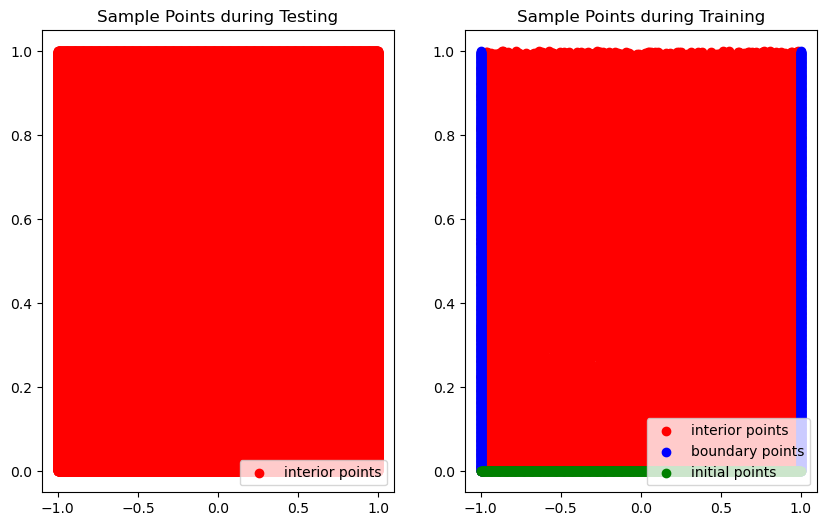

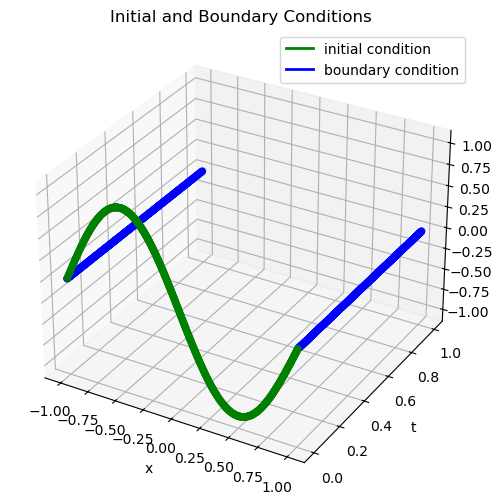

In [4]:
# 2. generate training and testing sample points
# 2-1. generate testing points over the entire domain
x = torch.linspace(x_min, x_max, traindata_size_initl)
t = torch.linspace(t_min, t_max, traindata_size_bndry)
X, T = torch.meshgrid(x,t,indexing="ij") 
testdata = torch.squeeze(torch.stack([X.reshape(1,traindata_size_initl*traindata_size_bndry), T.reshape(1,traindata_size_initl*traindata_size_bndry)], dim=-1))                

# 2-1. generate interior points
##### TODO: write code here #### traindata_intrr = ???

# 2-3. generate initial points and initial values
##### TODO: write code here #### traindata_initl = ???, u_exact_initl = ???

# 2-4. generate boundary points and boundary values
##### TODO: write code here #### traindata_bndry = ???, u_exact_bndry = ???

######################################################
fig1 = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(1, 2, 1)
plt.scatter(testdata[:,0], testdata[:,1], c = 'red', label = 'interior points' )
plt.title('Sample Points during Testing')
plt.legend(loc = 'lower right')

plt.subplot(1, 2, 2)
plt.scatter(traindata_intrr[:,0], traindata_intrr[:,1], c = 'red', label = 'interior points' )
plt.scatter(traindata_bndry[:,0], traindata_bndry[:,1], c = 'blue', label = 'boundary points' )
plt.scatter(traindata_initl[:,0], traindata_initl[:,1], c = 'green', label = 'initial points' )
plt.title('Sample Points during Training')
plt.legend(loc = 'lower right')
######################################################
fig2 = plt.figure(figsize=(10, 6), dpi= 100)
ax1 = plt.axes(projection ='3d')
ax1.scatter(traindata_initl[:,0], traindata_initl[:,1], u_exact_initl, c = 'green' )
ax1.plot3D(traindata_initl[:,0], traindata_initl[:,1], u_exact_initl, lw=2, c = 'green', label="initial condition" )

ax1.scatter(traindata_bndry[:,0], traindata_bndry[:,1], u_exact_bndry, c = 'blue')
ax1.plot3D(traindata_bndry[0:traindata_size_bndry,0], traindata_bndry[0:traindata_size_bndry,1], u_exact_bndry[0:traindata_size_bndry], lw=2, c = 'blue', label="boundary condition" )
ax1.plot3D(traindata_bndry[traindata_size_bndry:2*traindata_size_bndry,0], traindata_bndry[traindata_size_bndry:2*traindata_size_bndry,1], u_exact_bndry[traindata_size_bndry:2*traindata_size_bndry], lw=2, c = 'blue' )
plt.xlabel('x')
plt.ylabel('t')
plt.title('Initial and Boundary Conditions')
plt.legend();
######################################################

### 训练阶段

Done in 0:23:38.195152 !


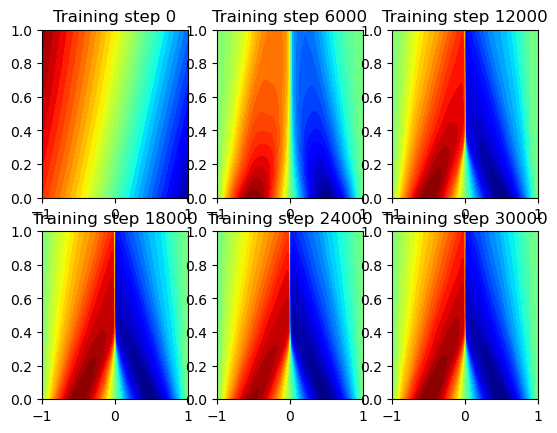

In [5]:
torch.manual_seed(123) # for reproducibility

# 1. construct a neural network to train
u_NN = FCN(LIST_LAYERS)

# 2. training process
optimizer = torch.optim.Adam(u_NN.parameters(), lr=1e-2, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.985)

since = time.time()
for i in range(32001):
    
    # compute each term of the PINN loss function above 
    # initial loss    
    u_initl = u_NN(traindata_initl)
    ##### TODO: write code here #### loss_initl = ???
    
    # boundary loss  
    u_bndry = u_NN(traindata_bndry)
    ##### TODO: write code here #### loss_bndry = ???
    
    # physics loss
    traindata_intrr.requires_grad = True
    u_intrr = u_NN(traindata_intrr)
    ##### TODO: write code here #### loss_intrr = ??? 
    
    # backpropagate joint loss, take optimiser step
    loss = loss_intrr + lmbda * (loss_initl + loss_bndry)
    
    # zero parameter gradients
    optimizer.zero_grad()
    # backpropagation
    loss.backward()
    # parameter update
    optimizer.step() 
    
    # plot the result as training progresses
    list_of_plots = []
    plt.rcdefaults()

    if i % 6000 == 0: 
        ax = plt.subplot(2, 3, i // 6000 + 1)
        
        u_test = u_NN(testdata).detach()
        u_test = u_test.reshape(traindata_size_initl, traindata_size_bndry)    

        ax.contourf(X, T, u_test, 40, cmap = 'jet')        
        ax.set_title(f"Training step {i}")
        
        list_of_plots.append(ax)
        
time_elapsed = time.time() - since
print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')

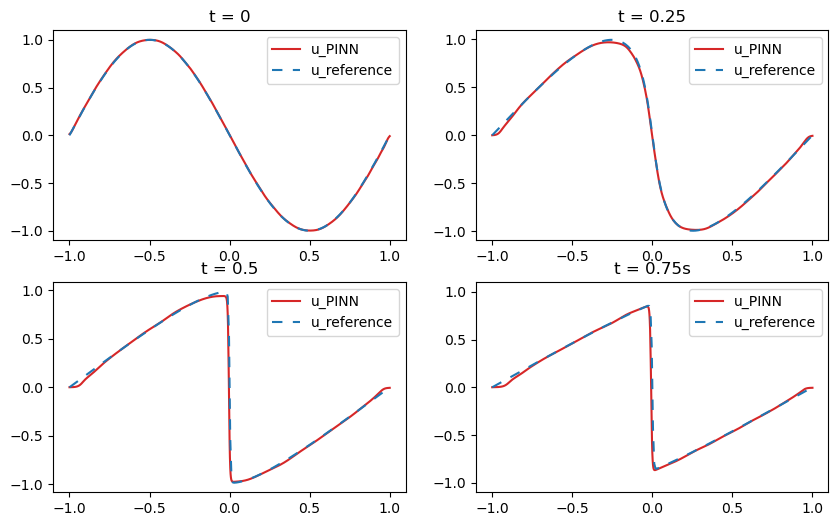

In [6]:
# reference solution
data = scipy.io.loadmat('reference_solution//Burgers.mat') 
x_reference = data['x']                                   # 256 points between -1 and 1 [256x1]
t_reference = data['t']                                   # 100 time points between 0 and 1 [100x1] 
u_reference = data['usol']                                # solution of 256x100 grid points

# trained network solution
u_test = u_NN(testdata).detach()
u_test = u_test.reshape(traindata_size_initl, traindata_size_bndry) 

fig3 = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(2, 2, 1)
plt.plot(x, u_test[:,0], label="u_PINN", color="tab:red")
plt.plot(x_reference, u_reference[:,0], linestyle='dashed', dashes=(5, 5), label="u_reference", color="tab:blue")
plt.title('t = 0')
plt.legend(loc = 'upper right')

plt.subplot(2, 2, 2)
plt.plot(x, u_test[:,traindata_size_bndry // 4 - 1], label="u_PINN", color="tab:red")
plt.plot(x_reference, u_reference.T[25,:], linestyle='dashed', dashes=(5, 5), label="u_reference", color="tab:blue")
plt.title('t = 0.25')
plt.legend(loc = 'upper right')

plt.subplot(2, 2, 3)
plt.plot(x, u_test[:,traindata_size_bndry // 2 - 1], label="u_PINN", color="tab:red")
plt.plot(x_reference, u_reference.T[50,:], linestyle='dashed', dashes=(5, 5), label="u_reference", color="tab:blue")
plt.title('t = 0.5')
plt.legend(loc = 'upper right')

plt.subplot(2, 2, 4)
plt.plot(x, u_test[:,3 * traindata_size_bndry // 4 - 1], label="u_PINN", color="tab:red")
plt.plot(x_reference, u_reference.T[75,:], linestyle='dashed', dashes=(5, 5), label="u_reference", color="tab:blue")
plt.title('t = 0.75s')
plt.legend(loc = 'upper right')

plt.ylim(top=1.1)  # adjust the top leaving bottom unchanged
plt.ylim(bottom=-1.1)  # adjust the bottom leaving top unchanged
plt.show()  

## 2. 课后作业（Talk is cheap. Show me the code.）

### 小组作业 1（正问题）

- 用传统数值方法（有限差分、有限体积法等）和机器学习方法求解下述线性双曲方程并进行比较

$$
u_t + a(x) u_x = 0, ~~(x,t)\in [-1,1]\times (0,8],
$$
$$
u(x,0) = \sin(\pi x), ~~x\in [-1,1],
$$
$$
u(-1,t)= u(1,t),~~ t\in (0,T],
$$

$~~~~~~$ 其中变系数 $a(x) = \pi^{-1}\sin(\pi x -1)$ 在 $x \approx \pi^{-1}-1$ 附近变号，解析解 $u(x,t) = \sin\Big( 2\, \mathrm{arctan}\big[ e^{-t}\tan\left( \frac{\pi x -1 }{2} \right) \big] + 1 \Big)$。

<center><img src="figures//HW-Hyperbolic-1.jpg" width="500"></center>

### 小组作业 2（反问题）
- 假设粘性 Burgers 方程中的系数 $\lambda_1$ 和 $\lambda_2$ 未知，即
$$
u_t + \lambda_1 u u_x - \lambda_2 u_{xx} = 0, ~~(x,t)\in [-1,1]\times (0,8],
$$
$$
u(x,0) = \sin(\pi x), ~~x\in [-1,1],
$$
$$
u(-1,t)= u(1,t),~~ t\in (0,T],
$$
$~~~~~~$ 且已知流场流速的在若干位置和时刻的测量信息 $\{ u(x_i,t_i)\}$（可以用参考解来生成数据），用 PINNs 对方程的解 $u(x,t)$ 和未知系数 $(\lambda_1,\lambda_2)$ 进行反演，探讨数据噪音（及其频率大小）对反演精度的影响。

- 参考资料：https://github.com/jdtoscano94/Learning-Scientific_Machine_Learning_Residual_Based_Attention_PINNs_DeepONets/blob/main/Tutorials/

<center><img src="figures//iPINNs-Burgers.jpg" width="500"></center>

### 小组作业 3（反问题）

- 在用物理信息神经网络求解粘性 Burgers 方程的过程中，将惩罚系数 $\lambda$ 也看作为可训练的参数，实现网络训练过程中的自适应调节。

- 参考资料：https://www.sciencedirect.com/science/article/abs/pii/S0021999122007859。